In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [56]:
import tensorflow as tf
import os
import random
import numpy as np
import keras.backend as K
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from tqdm import tqdm
 
from tensorflow.keras.callbacks import TensorBoard
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import  gray2rgb, rgb2gray
import matplotlib.pyplot as plt

In [6]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [7]:
dict_data=load('/content/drive/My Drive/deep learning/CHIP DATASET/akshay_data.npz')

X_train = dict_data['arr_0']
Y_train = dict_data['arr_1']
edgemap = dict_data['arr_2']
X_val = dict_data['arr_3']
Y_val = dict_data['arr_4']
X_test = dict_data['arr_5']
print(X_train.shape)
print(Y_train.shape)
print(edgemap.shape)
train_length = 28280
val_length = 5000
test_length = 5000

(28280, 128, 128, 3)
(28280, 128, 128, 1)
(28280, 128, 128, 1)


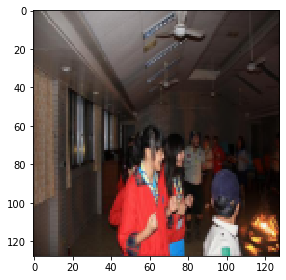

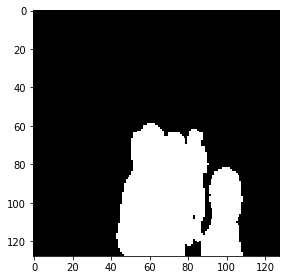

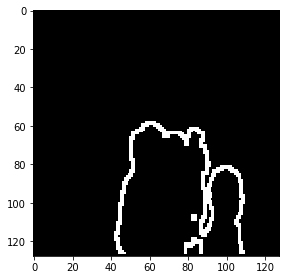

In [8]:
image_x = random.randint(0, train_length)
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()
imshow(np.squeeze(edgemap[image_x]))
plt.show()

In [9]:
model1 = tf.keras.models.load_model('/content/drive/My Drive/internship project/Trained Model saved/Akshay_Edge_Net.h5')
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 1)       33        
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [10]:
preds_edge_val = model1.predict( Y_val, verbose=1 )
preds_edge_val_t = (preds_edge_val > 0.5).astype( np.uint8 )

157/157 [==============================] - 37s 233ms/step


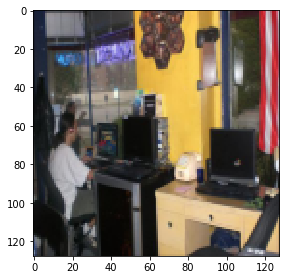

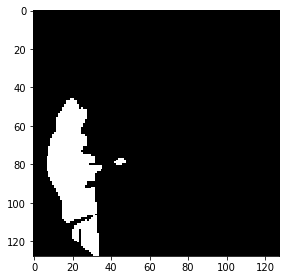

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


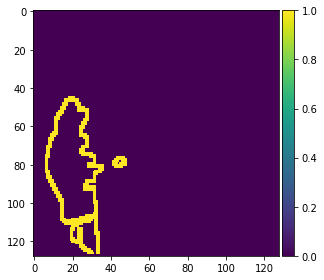

In [11]:
ix3 = random.randint(0, val_length)
imshow(X_val[ix3])
plt.show()
imshow(np.squeeze(Y_val[ix3]))
plt.show()
imshow(np.squeeze(preds_edge_val_t[ix3]))
plt.show()

In [12]:
model1.layers[0]._name='zero'
model1.layers[1]._name='first'
model1.layers[2]._name='second'
model1.layers[3]._name='third'

lambda1=1
lambda2=0.5
lambda3=0.25

In [13]:
def loss_fn(y_true,y_predict):
  y_true=tf.cast(y_true,tf.float32)
  y_predict=tf.cast(y_predict,tf.float32)
  
  
  # for layers 1  (128,128,16)
  layer_output1=model1.get_layer('first').output
  
  model_layer1=tf.keras.models.Model(inputs=model1.input,outputs=layer_output1)
  
  E1_hat=model_layer1(y_predict)
  E1=model_layer1(y_true)
  
  diff1=tf.keras.backend.abs(E1_hat-E1)
  
  # for layers 2 (128,128,32)
  layer_output2=model1.get_layer('second').output
  model_layer2=tf.keras.models.Model(inputs=model1.input,outputs=layer_output2)
  E2_hat=model_layer2(y_predict)
  E2=model_layer2(y_true)
  diff2=tf.keras.backend.abs(E2_hat-E2)
  

  #for output layer (128,128,1)
  E3_hat=model1(y_predict)
  E3=model1(y_true)
  diff3=tf.keras.backend.abs(E3_hat-E3)
  
  
  #total loss
  sum1=(lambda1*tf.reduce_sum(diff1))  + (lambda2*tf.reduce_sum(diff2))+(lambda3*tf.reduce_sum(diff3))
  
  
  sum2=tf.keras.losses.binary_crossentropy(y_true,y_predict)
  sum2=sum2+sum1

  return sum2

In [14]:
def sepConv(x,num_filter,strides=1):
  x=tf.keras.layers.DepthwiseConv2D(kernel_size=3,padding='same')(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Activation('relu')(x)
  x=tf.keras.layers.Conv2D(num_filter,kernel_size=(1,1),padding='same',strides=strides)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Activation('relu')(x)
  return x

In [15]:

def Conv(x,num_filter,kernel_size=3,strides=1):
  x=tf.keras.layers.Conv2D(num_filter,kernel_size=kernel_size,padding='same',strides=strides)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Activation('relu')(x)
  return x

In [16]:
def MobNet():
  inputs=tf.keras.layers.Input((128,128,3))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
  x1=Conv(s,num_filter=32,kernel_size=3,strides=1)
  x1=sepConv(x1,num_filter=32,strides=1)       # 128*128*32
  # down_sample block 2
  x2=tf.keras.layers.MaxPool2D((2,2),(2,2))(x1)
  x2=Conv(x2,num_filter=64,kernel_size=3)
  x2=sepConv(x2,num_filter=64,strides=1)   # 64*64*64
  # down_sample block 3
  x3=tf.keras.layers.MaxPool2D((2,2),(2,2))(x2)
  x3=Conv(x3,num_filter=128,kernel_size=3)
  x3=sepConv(x3,num_filter=128)   #32*32*128
  #down_sample block 4
  x4=tf.keras.layers.MaxPool2D((2,2),(2,2))(x3)
  x4=Conv(x4,num_filter=256,kernel_size=1)
  x4=sepConv(x4,num_filter=256)  #16*16*256

  #down_sample block 5
  x5=tf.keras.layers.MaxPool2D((2,2),(2,2))(x4)
  x5=Conv(x5,num_filter=512,kernel_size=1)
  x5=sepConv(x5,num_filter=512)    # 8*8*512
  # up_sampling block 1
  u1=tf.keras.layers.UpSampling2D((2,2))(x5)
  u1=tf.keras.layers.Concatenate()([u1,x4]) # 16*16*(512+256)
  u1=Conv(u1,num_filter=256,kernel_size=1)
  u1=sepConv(u1,num_filter=256) # 16*16*256
  #upsampling_block 2
  u2=tf.keras.layers.UpSampling2D((2,2))(u1)
  u2=tf.keras.layers.Concatenate()([u2,x3])  # 32*32*(256+128)
  u2=Conv(u2,num_filter=128,kernel_size=1)
  u2=sepConv(u2,num_filter=128)   # 32*32*128
  # upsampling block 3
  u3=tf.keras.layers.UpSampling2D((2,2))(u2)
  u3=tf.keras.layers.Concatenate()([u3,x2])
  u3=Conv(u3,num_filter=64,kernel_size=1)
  u3=sepConv(u3,num_filter=64) # 64*64*64
  # upsampling block 4
  u4=tf.keras.layers.UpSampling2D((2,2))(u3)
  u4=tf.keras.layers.Concatenate()([u4,x1])
  u4=Conv(u4,num_filter=32)
  u4=sepConv(u4,num_filter=32) 
  outputs=tf.keras.layers.Conv2D(1,(1,1),padding='same',activation='sigmoid')(u4)
  
  
  model=tf.keras.models.Model(inputs,outputs)
  return model


In [17]:
model=MobNet()
model.compile(optimizer="adam", loss=loss_fn, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [25]:
tensorboard_callback = TensorBoard(log_dir='./logs')
results = model.fit(X_train, Y_train,validation_data=(X_val,Y_val), batch_size=16, epochs=50, callbacks=[tensorboard_callback])
val_loss,val_accuracy = model.evaluate(X_val, Y_val)
print(val_loss,val_accuracy*100)
#summarize_diagnostics(results)



Epoch 1/50
1768/1768 [==============================] - 712s 403ms/step - loss: 2524526.5000 - mean_io_u_1: 0.2808 - val_loss: 1791950.8750 - val_mean_io_u_1: 0.3063
Epoch 2/50
1768/1768 [==============================] - 711s 402ms/step - loss: 1244593.1250 - mean_io_u_1: 0.2830 - val_loss: 1169200.7500 - val_mean_io_u_1: 0.2998
Epoch 3/50
1768/1768 [==============================] - 708s 400ms/step - loss: 1130448.8750 - mean_io_u_1: 0.2987 - val_loss: 1101996.2500 - val_mean_io_u_1: 0.3009
Epoch 4/50
1768/1768 [==============================] - 705s 399ms/step - loss: 1074065.5000 - mean_io_u_1: 0.3437 - val_loss: 1056046.2500 - val_mean_io_u_1: 0.3436
Epoch 5/50
1768/1768 [==============================] - 701s 396ms/step - loss: 1033128.7500 - mean_io_u_1: 0.4126 - val_loss: 1039816.6875 - val_mean_io_u_1: 0.4347
Epoch 6/50
1768/1768 [==============================] - 704s 398ms/step - loss: 1004403.3750 - mean_io_u_1: 0.4653 - val_loss: 1035614.1250 - val_mean_io_u_1: 0.3894
Epoc

In [76]:
model=tf.keras.models.load_model('/content/drive/My Drive/internship project/Trained Model saved/MobNet_with_semeda_and_binary_with_relu_with50_ephocs.h5',custom_objects={'loss_fn':loss_fn})

In [77]:
from keras.preprocessing.image import load_img,img_to_array,array_to_img
import time

<class 'numpy.ndarray'>


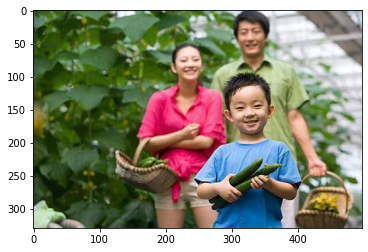

In [78]:
img=imread('/content/0038425.jpg')
plt.imshow(img)
print(type(img))

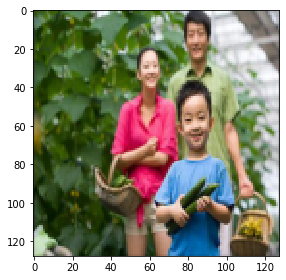

In [79]:
img=resize(img,(128,128),mode='constant',preserve_range=True)
img1=img.reshape((1,128,128,3))
img1=img1.astype(np.uint8)
imshow(img1[0])

In [92]:
start1=time.time()
Yhat=model.predict(img1)
start2=time.time()
print(start2-start1)

0.12825584411621094


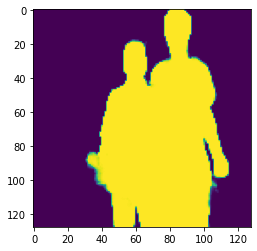

In [94]:
plt.imshow(np.squeeze(Yhat[0]))

In [87]:
model.save('MobNet_with_semeda_and_binary_with_relu_with50_ephocs.h5')

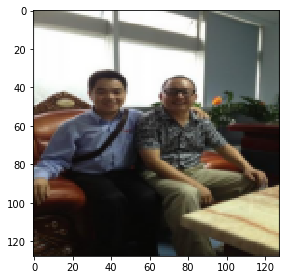

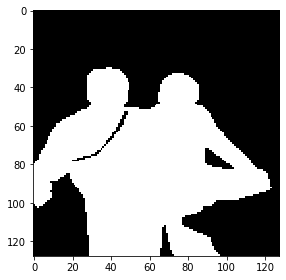

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


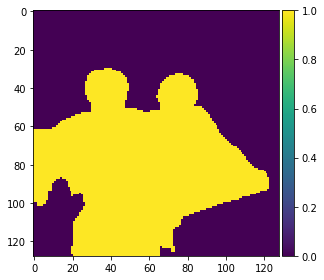

In [ ]:
#ix1 = random.randint(0, len(preds_train_t))
imshow(X_train[3])
plt.show()
imshow(np.squeeze(Y_train[3]))
plt.show()
imshow(np.squeeze(preds_train_t[3]))
plt.show()

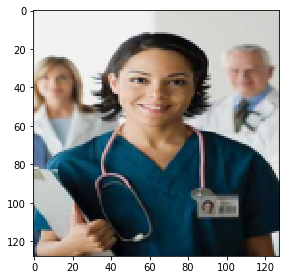

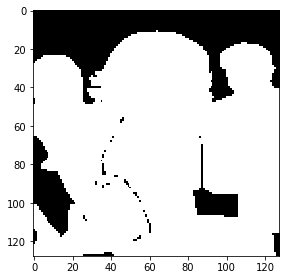

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


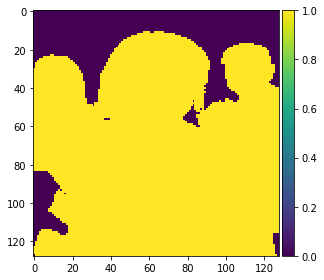

In [ ]:
ix2 = random.randint(0, len(preds_val_t))
imshow(X_val[120])
plt.show()
imshow(np.squeeze(Y_val[120]))
plt.show()
imshow(np.squeeze(preds_val_t[120]))
plt.show()

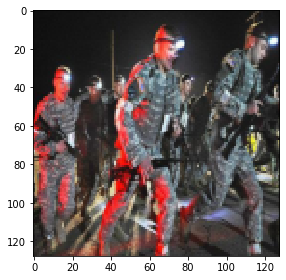

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


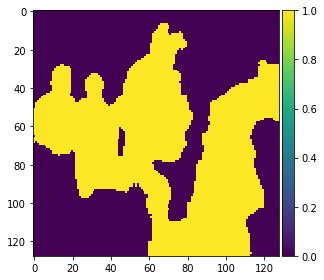

In [ ]:
ix3 = random.randint(0, len(preds_test_t))
imshow(X_test[30])
plt.show()
imshow(np.squeeze(preds_test_t[30]))
plt.show()